In [ ]:
import transformers
import torch
import os
from transformers import AutoTokenizer, AutoModelForCausalLM

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM
from langchain_openai.llms import OpenAI
from langchain_openai.chat_models import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings

In [ ]:
from dotenv import  load_dotenv
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [ ]:
import os
import pdfminer
#from pdfminer.utils import  open_filename
from unstructured.partition.pdf import partition_pdf
from unstructured.staging.base import elements_to_json
import pytesseract
os.environ['PATH'] += r';C:\Program Files\Tesseract-OCR' # dodajem tesseract u Path varijable
from pdf_parsing_and_chunking import parse_pdf

In [ ]:
chunks = parse_pdf() # ovde je parsiran tekst

In [ ]:
import pickle

#with open("chunks.pkl","wb") as file:
#    pickle.dump(chunks,file)

with open('results/chunked_elements_1.pkl', 'rb') as file: # test_chunks.pkl, test_chunks_max_1600.pkl
    chunks = pickle.load(file)

In [ ]:
len(chunks)

1310

In [ ]:
raw_pdf_elements = chunks

**Set of categories from pdf document:**

In [ ]:
from collections import defaultdict
categories = defaultdict(int)
for chunk in raw_pdf_elements:
    category = chunk.category
    categories[category] += 1

set_of_categories = set(categories.keys())

In [ ]:
categories

defaultdict(int, {'CompositeElement': 1206, 'Table': 104})

**Now we will create DATA MODEL with 2 fields: first one is type - type of pdf documents' element and text - text from element.**

In [ ]:
from pydantic import BaseModel
from typing import Any
from pydantic import Field

class Element(BaseModel):
    type:str = Field(description="Type of pdf documents' element.")
    text:Any = Field(description="This is text content of pdf document's element")
    page_no:int = Field(description="Page number of the original document from where chunk belongs.")

table_elements = list()
text_elements = list()

for element in raw_pdf_elements:
    if "CompositeElement" == element.category:
        text_elements.append(Element(type="text",text=element.text,page_no=dict(element.metadata.fields)['page_number']))
    elif "Table" == element.category:
        table_elements.append(Element(type="table",text=element.metadata.text_as_html,page_no=dict(element.metadata.fields)['page_number'])) # metadata.text_as_html

In [ ]:
with open('results/raw_txt_elements.pkl', 'wb') as file:
    pickle.dump(text_elements,file)

In [ ]:
with open('results/raw_table_elements.pkl', 'wb') as file:
    pickle.dump(table_elements,file)

In [ ]:
with open('results/raw_txt_elements.pkl','rb') as fl1:
    text_elements = pickle.load(fl1)
with open('results/raw_table_elements.pkl','rb') as fl2:
    table_elements = pickle.load(fl2)

**For text and tables we will create summaries**

In [ ]:
OPEN_API_KEY = os.getenv("OPENAI_API_KEY")
chat = ChatOpenAI(openai_api_key=OPEN_API_KEY,model="gpt-3.5-turbo",temperature=0) # gpt-4o-mini


In [ ]:
chat.invoke("Hello!")

AIMessage(content='Hello! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 9, 'total_tokens': 18}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-dd5839e1-0cfb-43f5-b022-27e41b9275a3-0', usage_metadata={'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 18})

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import AIMessage

def parse(ai_message: AIMessage) -> str:
    """Parse the AI message."""
    return ai_message.content

prompt_text = """ You are an assistant who's task is to summarize tables and chunks made of text. \
Retrieve the summary response in the following format: ''
Give precise and informative summary of table or text. Table or text element \
is provided to you from following content: {element}
"""
prompt = ChatPromptTemplate.from_template(prompt_text)

summarize_chain = {"element":lambda x: x} | prompt | chat | parse

**txt representations of formulas created by LLM**

In [ ]:
import pickle

with open("../data/formulas/latex_formulas.pkl","rb") as file:
    formulas = pickle.load(file)

In [ ]:
problem_example = r"\delta_k(x) = x^T \Sigma^{{-1}} \mu_k - \frac{{1}}{{2}} \mu_k^T \Sigma^{{-1}} \mu_k + \log \pi_k "

formulas_template = f"""You are an assistant who has a task to describe LaTex formula content by words.
This is example of your task: \n
Problem: {problem_example}""" + """
Solution: delta k(x) = x transpose Sigma inverse mu k - 1/2 mu k transpose Sigma inverse mu k + log pi k
You will execute your task on this formula:{formula} and return solution in format: Formula -> solution.
"""
formulas_prompt = ChatPromptTemplate.from_template(formulas_template)
describe_formula_chain = formulas_prompt | chat | StrOutputParser()

In [ ]:
formula_descriptions = []
for formula in formulas:
    answer = describe_formula_chain.invoke({"formula":formula[1]})
    print(answer)
    formula_descriptions.append((formula[0],answer))

Formula -> delta k(x) = x transpose Sigma inverse mu k - 1/2 mu k transpose Sigma inverse mu k + log pi k.
Formula -> X equals the matrix with elements x subscript 11, x subscript 12, and so on up to x subscript 1p in the first row; x subscript 21, x subscript 22, and so on up to x subscript 2p in the second row; and continuing with n rows, where each row contains elements x subscript n1, x subscript n2, and so on up to x subscript n p.
Formula: x_{i}=\left({\frac{x_{i1}}{x_{i2}}}\right)  
Solution: x i equals the fraction of x i1 over x i2.
Formula -> x equals a column vector with elements x two prime, x two prime, and so on, up to x n prime.
Formula: \mathbf{X}=\left(\mathbf{x}_{1}\quad\mathbf{x}_{2}\quad\mathbf{\epsilon}\cdot\mathbf{\epsilon}\ \cdot\mathbf{\epsilon}\cdot\mathbf{\epsilon}\quad\mathbf{x}_{p}\right)  
Solution: X equals the matrix formed by x one, x two, epsilon dot epsilon dot epsilon dot epsilon, and x p.
Formula -> X transpose = ( x 11 & x 21 & dots & x n1 \\ x 12 &

In [ ]:
with open("results/formula_descriptions.pkl","wb") as file:
    pickle.dump(formula_descriptions,file)

In [ ]:
with open("results/formula_descriptions.pkl","rb") as file:
    formula_descriptions = pickle.load(file)

**Sumarizacija tekstualnog sadržaja**

In [ ]:
text_originals = [element.text for element in text_elements]
text_summaries = summarize_chain.batch(text_originals,{"max_concurrency":5})

**Sumarizacija tabelarnog sadržaja**

In [ ]:
table_originals = [table.text for table in table_elements]
table_summaries = summarize_chain.batch(table_originals,{"max_concurrency":5})

In [ ]:
with open('results/chunking_strategy_4/4_table_summaries.pkl','rb') as fl1:
    table_summaries = pickle.load(fl1)
with open('results/chunking_strategy_4/4_txt_summaries.pkl','rb') as fl2:
    text_summaries = pickle.load(fl2)

In [ ]:
import pickle
with open("results/chunking_strategy_4/4_txt_summaries.pkl","wb") as file:
    pickle.dump(text_summaries,file)

with open("results/chunking_strategy_4/4_table_summaries.pkl","wb") as file2:
    pickle.dump(table_summaries,file2)

**Kreiranje summary-ja za slike**

In [ ]:
import io
import base64
from PIL import Image
from langchain_core.messages import HumanMessage
import uuid
from langchain.retrievers.multi_vector import MultiVectorRetriever, SearchType
from langchain.storage import InMemoryStore
from langchain_core.documents import Document
from langchain_chroma import Chroma



gpt_vision_llm = ChatOpenAI(model="gpt-4o",openai_api_key=OPEN_API_KEY) # gpt-4-vision-preview je zamenjen gpt-4o modelom

def image_to_base64(img_path):
    with Image.open(img_path) as image:
        buffered = io.BytesIO()
        image.save(buffered,format=image.format)
        img_str = base64.b64encode(buffered.getvalue())
        return img_str.decode('utf-8')


def get_jpg_files(folder_path):
    jpg_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith('.jpg'):
                jpg_files.append(os.path.join(root,file))
    return jpg_files

def get_decoded_representations():
    representations = list()
    folder_path = "figures/" # ovaj direktorijum je izbacen iz koda, slike su prebačene u bucket
    jpg_files = get_jpg_files(folder_path)
    for jpg_path in jpg_files:
        print(jpg_path)
        representations.append((jpg_path,image_to_base64(jpg_path)))
    return representations
representations = get_decoded_representations()

image_summaries = []

for representation in representations:
    summary = gpt_vision_llm.invoke([
    HumanMessage(
        content=[
            {"type":"text","text":"Please give me a summary of the image provided. Be descriptive."},
            {
                "type":"image_url",
                "image_url":{
                    "url":f"data:image/jpeg;base64,{representation[1]}"
                }
            }
            ]
        )
    ])
    image_summaries.append((representation[0],summary.content))

In [ ]:
with open("results/1_image_summaries.pkl","wb") as file2:
    pickle.dump(image_summaries,file2)

In [ ]:
with open('results/1_image_summaries.pkl','rb') as fl3:
    image_summaries = pickle.load(fl3)

In [ ]:
image_summaries[0]

('figures/figure-101-32.jpg',
 'The image is a matrix of scatter plots showing pairwise relationships between six different variables: Balance, Age, Cards, Education, Income, Limit, and Rating. Each variable is plotted against each other variable in the dataset. \n\n- **Diagonal (from top left to bottom right)**: These squares are blank or self-referential, providing no information as they represent each variable plotted against itself.\n\n- **Balance**: \n  - Positively correlated with Income, Limit, and Rating, as seen from the upward trends in the corresponding scatter plots.\n  - No clear pattern with Age, Cards, and Education.\n\n- **Age**:\n  - No clear correlation with Balance, Cards, Education, Income, Limit, or Rating.\n\n- **Cards**:\n  - No clear pattern with Balance, Age, Education, Income, Limit, or Rating.\n\n- **Education**:\n  - No clear pattern with Balance, Age, Cards, Income, Limit, or Rating.\n\n- **Income**:\n  - Positively correlated with Balance, Limit, and Ratin

**Kreiranje MultiVector retrievera koji za docstore ima InMemoryStore za originale dokumenata, a za vectorstore ima Chroma Vectorstore**

In [ ]:
from chroma_db_connection import create_retriever

chunks_path = "results/chunked_elements_1.pkl" # chunk_by_title strategy, combine_text_under_n_chars=1000,max_characters=1600, multipage_sections=True, new_after_n_chars=1200, overlap=True,
txt_summaries_path = "results/1_txt_summaries.pkl"
tbl_summaries_path = "results/1_table_summaries.pkl"
retriever = create_retriever(chunks_path,txt_summaries_path,tbl_summaries_path,"similarity",5)

1310 loaded from results/chunked_elements_1.pkl.
104 loaded from results/1_table_summaries.pkl.
1206 loaded from results/1_txt_summaries.pkl.
221 loaded from results/1_image_summaries.pkl.
268 loaded from results/formula_descriptions.pkl.
1799 documents stored.


In [ ]:
from chroma_db_connection import delete_collection
delete_collection(retriever)

In [ ]:
retriever.vectorstore.similarity_search_with_score("What is the F-statistic, and how is it used in multiple regression to test model significance?",k=4)

[(Document(metadata={'doc_id': 'ee4b571b-4087-49d7-bb4f-eae3a132f98d'}, page_content='The text discusses the use of F-statistics and t-statistics in regression analysis to evaluate the significance of predictors in a model. It explains that the F-statistic is calculated using the residual sum of squares from two models: one that includes all variables except a subset (g) and another that includes all variables. The t-statistics and p-values for individual predictors, as shown in Table 3.4, indicate their relationship with the response variable while controlling for other predictors. For example, it is noted that TV and radio are related to sales, but newspaper is not when controlling for the other two. The text emphasizes the importance of the overall F-statistic, particularly in models with many predictors, as relying solely on individual p-values can be misleading.'),
  0.17132410407066345),
 (Document(metadata={'doc_id': '82975cea-7cbc-4008-8acb-e1a6a65664da'}, page_content='The tex

In [ ]:
retriever.invoke("What is the F-statistic, and how is it used in multiple regression to test model significance?")

['Ho: Bp—g+1 = Bp—qt2 = +++ = Bp = 9,\n\nwhere for convenience we have put the variables chosen for omission at the end of the list. In this case we fit a second model that uses all the variables except those last g. Suppose that the residual sum of squares for that model is RSSo. Then the appropriate F-statistic is\n\n_ (RSSo — RSS)/q ~ RSS/(n— p—1) F (3.24)\n\nNotice that in Table 3.4, for each individual predictor a t-statistic and a p-value were reported. These provide information about whether each individual predictor is related to the response, after adjusting for the other predictors. It turns out that each of these is exactly equivalent’ to the F- test that omits that single variable from the model, leaving all the others in—i.e. g=1 in (3.24). So it reports the partial effect of adding that variable to the model. For instance, as we discussed earlier, these p-values indicate that TV and radio are related to sales, but that there is no evidence that newspaper is associated wit

In [ ]:
len(retriever.vectorstore.get()['documents'])

1799

**Document grader**

In [ ]:
# data model for structured output
class GradeDocument(BaseModel):
    """Checks if document is relevant for asked question."""
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

structured_llm_grader = chat.with_structured_output(GradeDocument)
system_grader = """
You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question
"""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_grader),
        ("human","Retrieved document: \n\n {document} \n\n User question: {question}"),
    ],
)
retrieval_grader = grade_prompt | structured_llm_grader

def grade_retrieved_documents(input_dictionary:dict):
    print("INPUT",input_dictionary)
    question = input_dictionary['question']
    documents = input_dictionary['context_documents']
    filtered_documents = []
    print(f"U funkciju za ocenjivanje dokumenata uslo je:{len(documents)}")
    for d in documents:
        #print("DOKUMENT:",d,"TIP:",type(d))
        score = retrieval_grader.invoke({"question":question,"document":d})
        if score.binary_score == "yes":
            filtered_documents.append(d)
        else:
            continue
    print(f"Broj dokumenata koji pripadaju datom kontekstu:{len(filtered_documents)}")
    print(filtered_documents)
    return {"context_documents":filtered_documents,"question":question}

**Multiple perspectives**

In [ ]:
from langchain_core.runnables import Runnable
from  langchain.load import dumps,loads
from operator import itemgetter
from langchain_core.runnables import RunnableLambda

def get_unique_union(documents: list[list]):
    """Method creates set of retrieved documents."""
    all_docs = [dumps(doc) for sublist in documents for doc in sublist]
    unique_docs = list(set(all_docs))
    return [loads(doc) for doc in unique_docs]

class MultiQuery(BaseModel):
    """Make a list of different perspectives of initial query."""
    queries: list[str] = Field(
        description="Given a user question make five different perspectives of initial query."
    )

def reciprocal_rank_fusion(results: list[list], k=60):
    """This method ranks documents based on the formula for fused scores and their individual rank from each question and optional parameter k"""
    fused_scores = {}
    for documents in results:
        for rank, document in enumerate(documents):
            document_string = dumps(document)
            if document_string not in fused_scores: # ako ne postoji ovaj dokument, dodati ga u listu
                fused_scores[document_string] = 0
            previous_score = fused_scores[document_string] # svakako je prethodni skor 0 ili >0
            fused_scores[document_string] += 1/(rank + k)

    # sada je potrebno sortirati dokumente po formuli od najveceg skora do najmanjeg
    reranked_results = [(loads(doc), score) for doc, score in sorted(fused_scores.items(), key=lambda el: el[1], reverse=True)]
    return reranked_results

system = """You are an AI language model assistant. Your task is to generate five
different versions of the given user question to retrieve relevant documents from a vector
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search.
Provide these alternative questions separated by newlines. Original question: {question}
"""

fusion_template = ChatPromptTemplate.from_messages([
    ("system",system),
    ("human","{question}")
])

rag_fusion_llm = chat.with_structured_output(MultiQuery)
query_generation_chain = (
    fusion_template
    | rag_fusion_llm
)

multi_query_retrieval_with_rag_fusion_chain = (query_generation_chain
                                               |(lambda x: x.queries)
                                               | retriever.map()
                                               | reciprocal_rank_fusion
                                               )

final_chain_template = """
You don't have any knowledge in statistics and machine learning fields.
You are only allowed to answer the questions based on the data from provided context:
Also, you are not allowed to correct answers based on your knowledge not provided from the context.
Your answer must be completely created from the retrieved context.
You are not allowed to correct context provided to you based on your previous knowledge.
If answer is not contained in your context, you will tell to the user that you don't know the answer and sugest to the user to be more specific.
When you answer the question, you need to reference the explicit part of allowed context where answer came from, especialy if user asks you to provide formulas!

\n
Allowed context for answering the user question:
\n
\n
{context_documents}
\n
\n
Question: {question}
"""
final_prompt = ChatPromptTemplate.from_template(final_chain_template)
final_rag_chain = (
    {"context_documents":multi_query_retrieval_with_rag_fusion_chain,
     "question":itemgetter("question")}
    | RunnableLambda(grade_retrieved_documents) # retrieval check, validacija da li je pitanje utemeljeno sa kontekstom
    | final_prompt
    | chat
    | StrOutputParser()
)
retriever.search_kwargs = {"k":20}

In [ ]:
from query_translation import load_generalization_query_chain
result = final_rag_chain.invoke({"question":"Tell me all classification metrics."})

INPUT {'context_documents': [('TABLE 4.7. Important measures for classification and diagnostic testing, derived from quantities in Table 4.6.\n\nalternative (non-null) hypothesis. In the context of the Default data, “+” indicates an individual who defaults, and “—” indicates one who does not.\n\nTable 4.7 lists many of the popular performance measures that are used in this context. The denominators for the false positive and true positive rates are the actual population counts in each class. In contrast, the denominators for the positive predictive value and the negative predictive value are the total predicted counts for each class.', 0.08075130698081517), ('qualitative, 2, 27, 91, 135, 167, 202 variable, 91-94 quantitative, 2, 27, 91, 135, 167, 202 radial kernel, 381, 383, 390 random forest, 11, 331, 343, 346— 347, 354, 360-361 random seed, 46 re-sampling, 577-582 recall, 155 receiver operating characteristic (ROC), 154, 382-383 recommender systems, 516 rectified linear unit, 401 rec

In [ ]:
print(result)

The classification metrics mentioned in the provided context include:

1. **True Positive (TP)** - The count of correctly predicted positive instances.
2. **False Positive (FP)** - The count of incorrectly predicted positive instances.
3. **True Negative (TN)** - The count of correctly predicted negative instances.
4. **False Negative (FN)** - The count of incorrectly predicted negative instances.
5. **Training Error Rate** - The proportion of mistakes made when applying the classifier to the training observations, calculated using the formula:
   \[
   \text{Training Error Rate} = \frac{1}{n} \sum_{i=1}^{n} I(y_i \neq \hat{y}_i)
   \]
   where \( I(y_i \neq \hat{y}_i) \) is an indicator variable that equals 1 if the prediction is incorrect and 0 if it is correct.
6. **Positive Predictive Value (PPV)** - The proportion of true positive predictions among all positive predictions.
7. **Negative Predictive Value (NPV)** - The proportion of true negative predictions among all negative pred

In [ ]:
retriever.invoke("Show me from scratch how to perform linear regression in Python on Boston dataset.")

['8.6.2 Simple Linear Regression\n\nIn this section we will construct model matrices (also called design matri- ces) using the ModelSpec() transform from ISLP.models.\n\nWe will use the Boston housing data set, which is contained in the ISLP package. The Boston dataset records medv (median house value) for 506 neighborhoods around Boston. We will build a regression model to pre- dict medv using 13 predictors such as rmvar (average number of rooms per house), age (proportion of owner-occupied units built prior to 1940), and lstat (percent of households with low socioeconomic status). We will use statsmodels for this task, a Python package that implements several com- monly used regression methods.\n\nWe have included a simple loading function load_data() in the ISLP pack- age: load_data()\n\nIn [8]:| Boston = load_data("Boston") Boston.columns\n\nOut[8]: Index([\'crim\', \'zn\', \'indus\', \'chas\', \'nox\', \'rm\', \'age\', \'dis\', ‘\'rad\', \'tax\', \'ptratio\', \'black\', \'lstat\',

In [ ]:
result2 = final_rag_chain.invoke({"question":"explanation to me ridge regression on the Credit dataset and show me formula for it."})

INPUT {'context_documents': [('An Application to the Credit Data\n\nIn Figure 6.4, the ridge regression coefficient estimates for the Credit data set are displayed. In the left-hand panel, each curve corresponds to the ridge regression coefficient estimate for one of the ten variables, plotted as a function of \\. For example, the black solid line represents the ridge regression estimate for the income coefficient, as \\ is varied. At the extreme left-hand side of the plot, \\ is essentially zero, and so the corresponding ridge coefficient estimates are the same as the usual least squares esti- mates. But as A increases, the ridge coefficient estimates shrink towards zero. When X is extremely large, then all of the ridge coefficient estimates are basically zero; this corresponds to the model that contains no pre- dictors. In this plot, the income, limit, rating, and student variables are displayed in distinct colors, since these variables tend to have by far the largest coefficient est

In [ ]:
print(result2)

Cross-validation error is a method used to estimate the test error rate by holding out a subset of the training observations from the fitting process and then applying the statistical learning method to those held-out observations. 

In the context of classification problems, the cross-validation error can be quantified using the number of misclassified observations. The formula for the leave-one-out cross-validation (LOOCV) error rate is given as:

\[
\text{Err}_{CV(n)} = \frac{1}{n} \sum_{i=1}^{n} \text{Err}_i
\]

where \(\text{Err}_i\) is the error for the \(i\)-th observation, defined as \(I(y_i \neq \hat{y}_i)\), where \(I\) is an indicator function that equals 1 if the predicted value \(\hat{y}_i\) does not match the actual value \(y_i\).

This information is derived from the context provided, specifically from the section discussing cross-validation in classification problems and the formula for LOOCV error rate (source: "5.1.5 Cross-Validation on Classification Problems").


In [ ]:
retriever.invoke("explanation to me ridge regression on the Credit dataset and show me formula for it") # 18. dokument je pravi!!!!! NAPISAO SAM FORMULA I ONDA SE POJAVIO DRUGI
# Tell me formula for quadratic logistic regression model.

['An Application to the Credit Data\n\nIn Figure 6.4, the ridge regression coefficient estimates for the Credit data set are displayed. In the left-hand panel, each curve corresponds to the ridge regression coefficient estimate for one of the ten variables, plotted as a function of \\. For example, the black solid line represents the ridge regression estimate for the income coefficient, as \\ is varied. At the extreme left-hand side of the plot, \\ is essentially zero, and so the corresponding ridge coefficient estimates are the same as the usual least squares esti- mates. But as A increases, the ridge coefficient estimates shrink towards zero. When X is extremely large, then all of the ridge coefficient estimates are basically zero; this corresponds to the model that contains no pre- dictors. In this plot, the income, limit, rating, and student variables are displayed in distinct colors, since these variables tend to have by far the largest coefficient estimates. While the ridge coeff

In [ ]:
retriever.search_kwargs = {"k":20}

In [ ]:
from query_translation import load_hypodocument_chain

hydo_question = load_hypodocument_chain()
retrieval_chain =  hydo_question | retriever
retireved_docs = retrieval_chain.invoke({"question":"formula for standard error of bootstrap estimates."})
# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | chat
    | StrOutputParser()
)

final_rag_chain.invoke({"context":retireved_docs,"question":"Show me the comparison between Bayes and KNN decision boundary."})

'The provided context does not contain any information about Bayes classifiers or K-Nearest Neighbors (KNN) decision boundaries. It primarily discusses the bootstrap method, its application in estimating standard errors, and some examples related to linear regression and statistical learning methods.\n\nTo compare the decision boundaries of Bayes classifiers and KNN, we can summarize the general differences:\n\n1. **Bayes Classifier**:\n   - The Bayes classifier uses the concept of probability and assumes a probabilistic model of the data. It calculates the posterior probabilities of each class given the input features and assigns the class with the highest probability.\n   - The decision boundary is typically smooth and can be complex, depending on the underlying distribution of the data. It is influenced by the assumptions made about the distribution of the features (e.g., Gaussian distribution).\n\n2. **K-Nearest Neighbors (KNN)**:\n   - KNN is a non-parametric method that classifie

**Mongo**

In [ ]:
from mongo_db_connection import semantic_search

query =  "What is a studentized residual, and how is it used to identify outliers?"
#RunnableLambda(semantic_search).map(query)

mongo_db_retriever_chain = (query_generation_chain
                            |(lambda x: x.queries)
                            | RunnableLambda(semantic_search).map()
                            | reciprocal_rank_fusion
                            )
final_chain = (
    {"context_documents":mongo_db_retriever_chain,
     "question":itemgetter("question")}
    | RunnableLambda(grade_retrieved_documents)
    | final_prompt
    | chat
    | StrOutputParser()
)

In [ ]:
result = final_chain.invoke({"question":query}) # mongo db chain
print(result)

INPUT {'context_documents': [('Residual plots can be used to identify outliers. In this example, the out- lier is clearly visible in the residual plot illustrated in the center panel of Figure 3.12. But in practice, it can be difficult to decide how large a resid- ual needs to be before we consider the point to be an outlier. To address this problem, instead of plotting the residuals, we can plot the studentized residuals, computed by dividing each residual e; by its estimated standard error. Observations whose studentized residuals are greater than 3 in abso- lute value are possible outliers. In the right-hand panel of Figure 3.12, the outlier’s studentized residual exceeds 6, while all other observations have studentized residuals between —2 and 2.\n\nIf we believe that an outlier has occurred due tion or recording, then one solution is to simply remove the observation. However, care should be taken, since an outlier may instead indicate a deficiency with the model, such as a missing

In [ ]:
semantic_search(query)

['Residual plots can be used to identify outliers. In this example, the out- lier is clearly visible in the residual plot illustrated in the center panel of Figure 3.12. But in practice, it can be difficult to decide how large a resid- ual needs to be before we consider the point to be an outlier. To address this problem, instead of plotting the residuals, we can plot the studentized residuals, computed by dividing each residual e; by its estimated standard error. Observations whose studentized residuals are greater than 3 in abso- lute value are possible outliers. In the right-hand panel of Figure 3.12, the outlier’s studentized residual exceeds 6, while all other observations have studentized residuals between —2 and 2.\n\nIf we believe that an outlier has occurred due tion or recording, then one solution is to simply remove the observation. However, care should be taken, since an outlier may instead indicate a deficiency with the model, such as a missing predictor. o an error in dat

In [ ]:
chunks_path = "results/chunked_elements_1.pkl" # chunk_by_title strategy, combine_text_under_n_chars=1000,max_characters=1600, multipage_sections=True, new_after_n_chars=1200, overlap=True,
txt_summaries_path = "results/1_txt_summaries.pkl"
tbl_summaries_path = "results/1_table_summaries.pkl"
retriever = create_retriever(chunks_path,txt_summaries_path,tbl_summaries_path,"similarity",5)

1310 loaded from results/chunked_elements_1.pkl.
104 loaded from results/1_table_summaries.pkl.
1206 loaded from results/1_txt_summaries.pkl.
221 loaded from results/1_image_summaries.pkl.
268 loaded from results/formula_descriptions.pkl.
1799 documents stored.


In [ ]:
#delete_collection(retriever)
retriever.invoke(query)

In [ ]:
from faiss_db_connection import create_retriever
faiss_retriever = create_retriever()

In [ ]:
faiss_retriever.invoke(query)

[Element(type='text', text='Residual plots can be used to identify outliers. In this example, the out- lier is clearly visible in the residual plot illustrated in the center panel of Figure 3.12. But in practice, it can be difficult to decide how large a resid- ual needs to be before we consider the point to be an outlier. To address this problem, instead of plotting the residuals, we can plot the studentized residuals, computed by dividing each residual e; by its estimated standard error. Observations whose studentized residuals are greater than 3 in abso- lute value are possible outliers. In the right-hand panel of Figure 3.12, the outlier’s studentized residual exceeds 6, while all other observations have studentized residuals between —2 and 2.\n\nIf we believe that an outlier has occurred due tion or recording, then one solution is to simply remove the observation. However, care should be taken, since an outlier may instead indicate a deficiency with the model, such as a missing pr

**Chroma**

In [ ]:
result2 = final_rag_chain.invoke({"question":query}) # Chroma
print(result2)

INPUT {'context_documents': [('Residual plots can be used to identify outliers. In this example, the out- lier is clearly visible in the residual plot illustrated in the center panel of Figure 3.12. But in practice, it can be difficult to decide how large a resid- ual needs to be before we consider the point to be an outlier. To address this problem, instead of plotting the residuals, we can plot the studentized residuals, computed by dividing each residual e; by its estimated standard error. Observations whose studentized residuals are greater than 3 in abso- lute value are possible outliers. In the right-hand panel of Figure 3.12, the outlier’s studentized residual exceeds 6, while all other observations have studentized residuals between —2 and 2.\n\nIf we believe that an outlier has occurred due tion or recording, then one solution is to simply remove the observation. However, care should be taken, since an outlier may instead indicate a deficiency with the model, such as a missing

**FAISS**

In [ ]:
from faiss_db_connection import create_retriever

faiss_retriever = create_retriever()

In [ ]:
def retrieve_lists_of_text(data: list[list[Element]])->list[list[str]]:
    cleared_lists = []
    for elements_list in data:
        cleared_lists.append([elem.text for elem in elements_list])
    return cleared_lists


faiss_db_retriever_chain = (query_generation_chain
                            |(lambda x: x.queries)
                            | faiss_retriever.map()
                            | RunnableLambda(retrieve_lists_of_text)
                            | reciprocal_rank_fusion
                            )
final_faiss_chain = (
    {"context_documents":faiss_db_retriever_chain,
     "question":itemgetter("question")}
    | RunnableLambda(grade_retrieved_documents) # retrieval check
    | final_prompt
    | chat
    | StrOutputParser()
)

In [ ]:
result_faiss = final_faiss_chain.invoke({"question":query})
print(result_faiss)

INPUT {'context_documents': [('Residual plots can be used to identify outliers. In this example, the out- lier is clearly visible in the residual plot illustrated in the center panel of Figure 3.12. But in practice, it can be difficult to decide how large a resid- ual needs to be before we consider the point to be an outlier. To address this problem, instead of plotting the residuals, we can plot the studentized residuals, computed by dividing each residual e; by its estimated standard error. Observations whose studentized residuals are greater than 3 in abso- lute value are possible outliers. In the right-hand panel of Figure 3.12, the outlier’s studentized residual exceeds 6, while all other observations have studentized residuals between —2 and 2.\n\nIf we believe that an outlier has occurred due tion or recording, then one solution is to simply remove the observation. However, care should be taken, since an outlier may instead indicate a deficiency with the model, such as a missing

**RAPTOR** - Recursive Abstractive Processing for Tree-Organized Retrieval

In [ ]:
# Raptop - koristi se za kreiranje indeksa i retrieval dokumenata.
# 1. leafs = set startnih dokumenata (tabele, text i image summary-ji)
# 2. Leafs dobijaju svoje vektorske reprezentacije i bivaju klasterovani
# 3. Klasteri se sumarizuju u apstraktnije klastere sličnih dokumenata
# 4. ponavljanjem procesa, dobija se tree struktura čiji su listovi leafs, a koren root summary
import matplotlib.pyplot as plt
import tiktoken

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string)) # broj tokena enkodiranog stringa
    return num_tokens


In [ ]:
all_documents = [] # ovo su svi dokumenti
docs_texts = []
for k,v in zip(list(retriever.docstore.yield_keys()),retriever.docstore.mget(list(retriever.docstore.yield_keys()))):
    all_documents.append(Document(page_content=v,metadata={'id':k}))
    docs_texts.append(v)
token_counts = [num_tokens_from_string(d,"cl100k_base") for d in docs_texts]

<function matplotlib.pyplot.show(close=None, block=None)>

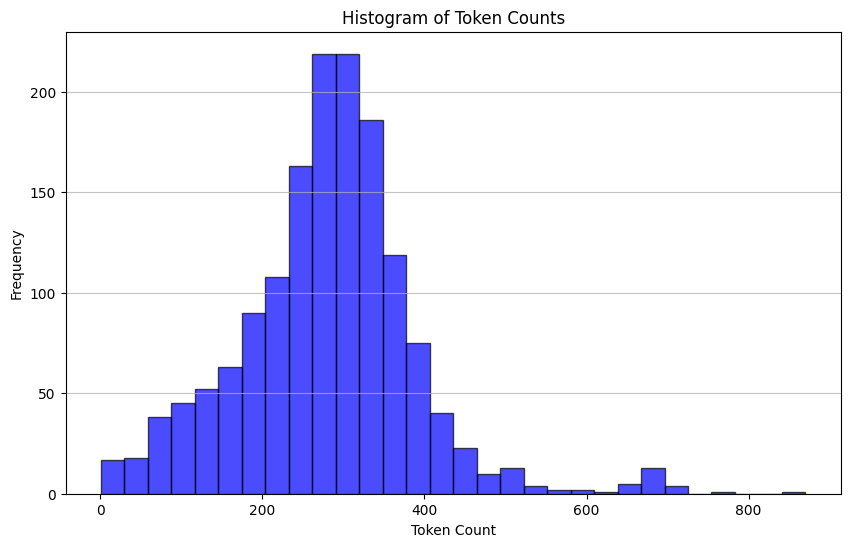

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(token_counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show

In [ ]:
from raptor import recursive_embed_cluster_summarize
leaf_texts = docs_texts

In [ ]:
results_raptor = recursive_embed_cluster_summarize(leaf_texts,level=1,n_levels=3)

c:\Users\Korisnik\virtual_environment\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


--Generated 246 clusters--


Failed to batch ingest runs: LangSmithRateLimitError('Rate limit exceeded for https://api.smith.langchain.com/runs/batch. HTTPError(\'429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/batch\', \'{"detail":"Monthly unique traces usage limit exceeded"}\')')
Failed to batch ingest runs: LangSmithRateLimitError('Rate limit exceeded for https://api.smith.langchain.com/runs/batch. HTTPError(\'429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/batch\', \'{"detail":"Monthly unique traces usage limit exceeded"}\')')
Failed to batch ingest runs: LangSmithRateLimitError('Rate limit exceeded for https://api.smith.langchain.com/runs/batch. HTTPError(\'429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/batch\', \'{"detail":"Monthly unique traces usage limit exceeded"}\')')
Failed to batch ingest runs: LangSmithRateLimitError('Rate limit exceeded for https://api.smith.langchain.com/runs/batch. HTTPError(\'42

--Generated 54 clusters--


Failed to batch ingest runs: LangSmithRateLimitError('Rate limit exceeded for https://api.smith.langchain.com/runs/batch. HTTPError(\'429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/batch\', \'{"detail":"Monthly unique traces usage limit exceeded"}\')')
Failed to batch ingest runs: LangSmithRateLimitError('Rate limit exceeded for https://api.smith.langchain.com/runs/batch. HTTPError(\'429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/batch\', \'{"detail":"Monthly unique traces usage limit exceeded"}\')')
Failed to batch ingest runs: LangSmithRateLimitError('Rate limit exceeded for https://api.smith.langchain.com/runs/batch. HTTPError(\'429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/batch\', \'{"detail":"Monthly unique traces usage limit exceeded"}\')')
Failed to batch ingest runs: LangSmithRateLimitError('Rate limit exceeded for https://api.smith.langchain.com/runs/batch. HTTPError(\'42

--Generated 10 clusters--


Failed to batch ingest runs: LangSmithRateLimitError('Rate limit exceeded for https://api.smith.langchain.com/runs/batch. HTTPError(\'429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/batch\', \'{"detail":"Monthly unique traces usage limit exceeded"}\')')
Failed to batch ingest runs: LangSmithRateLimitError('Rate limit exceeded for https://api.smith.langchain.com/runs/batch. HTTPError(\'429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/batch\', \'{"detail":"Monthly unique traces usage limit exceeded"}\')')
Failed to batch ingest runs: LangSmithRateLimitError('Rate limit exceeded for https://api.smith.langchain.com/runs/batch. HTTPError(\'429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/batch\', \'{"detail":"Monthly unique traces usage limit exceeded"}\')')


In [ ]:
results_raptor

{1: (                                                   text  \
  0     The image is a matrix of scatter plots showing...   
  1     The image consists of two line graphs, each di...   
  2     The image is a scatter plot that represents th...   
  3     The image consists of two residual plots side ...   
  4     The image contains three separate line charts,...   
  ...                                                 ...   
  1526  174, 181 random(), 555 RandomForestRegressor()...   
  1527  StandardScaler (), 185, 438, 537, 555 statsmod...   
  1528  qualitative, 2, 27, 91, 135, 167, 202 variable...   
  1529  elbow, 514 semi-supervised learning, 27 sensit...   
  1530  Ss\n\nSs\n\nregression, 386 survival analysis,...   
  
                                                     embd  cluster  
  0     [-0.015677038580179214, -0.003662582952529192,...  [159.0]  
  1     [-0.002979329554364085, -0.011187168769538403,...  [159.0]  
  2     [-0.009872213937342167, 0.0017569734482094646,.

In [ ]:
with open('results/raptor.pkl', 'wb') as fileraptor:
    pickle.dump(results_raptor,fileraptor)

In [ ]:
with open('results/raptor.pkl', 'rb') as fileraptor:
    raptor_data = pickle.load(fileraptor)

In [ ]:
all_texts = leaf_texts.copy()
for lvl in sorted(raptor_data.keys()):
    summaries_raptor = raptor_data[lvl][1]["summaries"].tolist()
    all_texts.extend(summaries_raptor)

In [ ]:
vectorstore_raptor = Chroma.from_texts(texts=all_texts,embedding=OpenAIEmbeddings(openai_api_key=OPEN_API_KEY))
retriever_raptor = vectorstore_raptor.as_retriever() # pisalo je samo vectorstore

In [ ]:
raptor_retriever_chain = (query_generation_chain
                            |(lambda x: x.queries)
                            | retriever_raptor.map()
                            #| RunnableLambda(retrieve_lists_of_text)
                            | reciprocal_rank_fusion # ovo radi nad svim dokumentima fuziju
                            )
final_raptor_chain = (
    {"context_documents":raptor_retriever_chain,
     "question":itemgetter("question")}
    | RunnableLambda(grade_retrieved_documents) # retrieval check
    | final_prompt
    | chat
    | StrOutputParser()
)

In [ ]:
final_raptor_chain.invoke({"question":query})

INPUT {'context_documents': [(Document(metadata={'doc_id': 'df0a7b11-527f-4624-aa16-d0fd86e4cda8'}, page_content='Residual plots help identify outliers in data analysis. In the example provided, an outlier is visible in the residual plot. However, determining the threshold for what constitutes an outlier can be challenging. To improve this, studentized residuals are used, calculated by dividing each residual by its estimated standard error. Observations with studentized residuals greater than 3 in absolute value are considered potential outliers. In the example, one outlier has a studentized residual exceeding 6, while others range between -2 and 2. If an outlier is suspected due to data collection errors, it may be removed, but caution is advised as it could also indicate model deficiencies, such as missing predictors.'), 0.08333333333333333), (Document(metadata={'doc_id': 'bfddef66-f737-47cd-9728-13d78c51f448'}, page_content='The text discusses the concept of variance in responses an

'A studentized residual is a type of residual that has been standardized by dividing it by its estimated standard error. This process allows for a more accurate assessment of how far an observation deviates from the predicted values in a regression model. \n\nIn the context of identifying outliers, studentized residuals are particularly useful because they provide a way to quantify the extremity of a residual relative to the variability of the data. Observations with studentized residuals greater than 3 in absolute value are typically considered potential outliers. For example, if a studentized residual exceeds 6, as noted in the provided context, it indicates a significant deviation from the expected value, marking it as a strong candidate for being an outlier. \n\nOverall, studentized residuals help analysts identify points that may be problematic due to data collection errors or model deficiencies, guiding decisions on whether to investigate or potentially remove these outliers from